## Variational inference in Dirichlet Process Normal Mixture

In [9]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.WishartParams import WishartParam
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt
import DP_lrvb as lrvb

from copy import deepcopy

import scipy as osp
from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [10]:
np.random.seed(52432)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 2 # true number of clusters

true_info_x = 0.1 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(true_info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_wishart_dof = x_dim
prior_wishart_scale = true_info_x / prior_wishart_dof
kappa = 0.001

# variational truncation 
k_approx = 10



observed mixture proportions: 
 [ 0.514  0.486]
true mixture proportions: 
 [ 0.5  0.5]


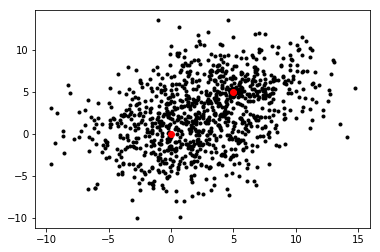

In [11]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

# Set up VB model and initialize

In [12]:
# global parameters
global_params = ModelParamsDict('global')

# variational MVN parameters
global_params.push_param(
    PosDefMatrixParamVector(name='info_mu', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means

# variational beta parameters
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation

# variational wishart parameters
global_params.push_param(
    WishartParam(name = 'wishart', size = x_dim))
    
    
# variational wishart parameters
# global_params.push_param(
#     PosDefMatrixParam(name='inv_wishart_scale', size = x_dim))
# global_params.push_param(
#     ScalarParam(name='wishart_dof', lb = x_dim - 1))


In [13]:
# local indicators
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)

In [14]:
# prior paramters
prior_params = ModelParamsDict('prior_params')

# prior mean
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))

# prior wishart parameters
prior_params.push_param(WishartParam(name = 'prior wishart', size = x_dim))
prior_params['prior wishart'].params['v'].set(prior_wishart_scale)
prior_params['prior wishart'].params['df'].set(prior_wishart_dof)


prior_params.push_param(ScalarParam(name='kappa', val = kappa))

# dp paramter
prior_params.push_param(ScalarParam(name='alpha', val=alpha))


In [15]:
## initialize VB params

vb_params.set_free(np.random.random(vb_params.free_size()))

#vb_params['global']['inv_wishart_scale'].set(np.linalg.inv(true_info_x / x_dim))
#vb_params['global']['wishart_dof'].set(np.array([x_dim]))

# vb_params['global']['mu'].set(true_mu)

init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

model = dp.DPNormalMixture(x, vb_params, prior_params)

# Run CAVI 

CAVI terminated successfully :)
iterations ran:  1634
kl:  [ 3790.0023927]


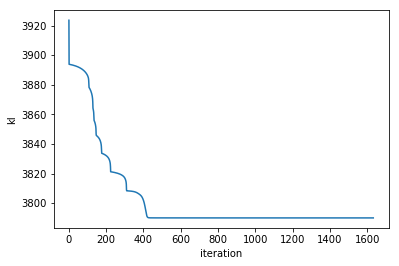

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 2000, tol = 1e-8, disp = False)
cavi_results = deepcopy(model)
print('kl: ', cavi_results.get_kl())


### examine results of CAVI

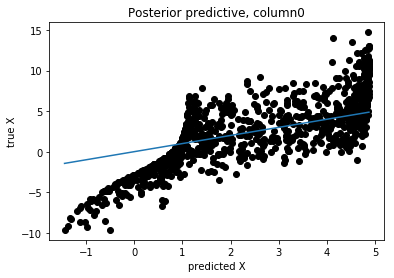

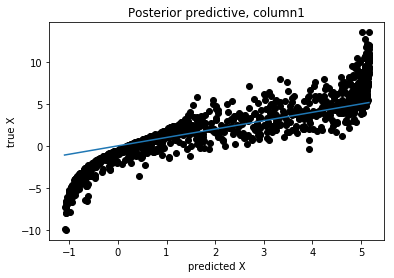

In [35]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [36]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))


heavy_clusters = post_pi > 1 / 100 # k_approx # clusters with significant weights 

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi)
print('significant proportions', post_pi[heavy_clusters], '\n')

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)



true_proportions [ 0.5  0.5]
estimated proportions:  [  3.59378955e-01   4.83841883e-01   1.54800804e-01   6.59452661e-04
   4.39635107e-04   2.93090071e-04   1.95393381e-04   1.30262254e-04
   8.68415027e-05   1.73683005e-04]
significant proportions [ 0.35937896  0.48384188  0.1548008 ] 

true number of clusters:  2
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  3
recall variational truncation:  10


In [37]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
post_mean = cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :]
print(post_mean)

true means: 
[[0 0]
 [5 5]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[ 1.10073553 -1.12680605]
 [ 4.871117    5.16491909]
 [-1.68552985  1.57528819]]


here, black are data points. red are the true means. blue are the posterior means
blue circles are two std deviations


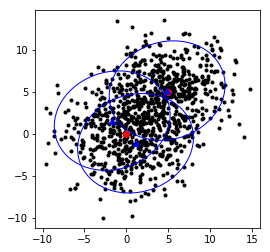

In [38]:
# visualize the data
from matplotlib.patches import Ellipse

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')

e_cov_x = np.linalg.inv(cavi_results.vb_params['global']['wishart'].params['v'].get()) / \
                cavi_results.vb_params['global']['wishart'].params['df'].get()

lambda_, v = np.linalg.eig(e_cov_x)
lambda_ = np.sqrt(lambda_)

for i in range(np.shape(post_mean)[0]): 
    ell = Ellipse(xy=(post_mean[i, 0], post_mean[i, 1]),
                      width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_edgecolor('blue')
    ell.set_facecolor('none')
    ax.add_artist(ell)
    
plt.scatter(x[:,0], x[:,1], c = 'black', marker = '.')

for k in range(k_true):
    plt.scatter(true_mu[k, 0], true_mu[k, 1], c = 'red')

for k in range(np.shape(post_mean)[0]):
    plt.scatter(post_mean[k, 0], post_mean[k, 1], c = 'blue', marker = '^')
    

print('here, black are data points. red are the true means. blue are the posterior means')
print('blue circles are two std deviations')

# Newton Optimization

In [39]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [40]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-6, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

Optimization terminated successfully.
         Current function value: 3789.986776
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 0
done :o


In [41]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [42]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value 3789.98677628
L_inf norm of gradient:  8.49384813505e-07
time to compute Hessian (sec):  11.032517671585083
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  5.56941688247e-07


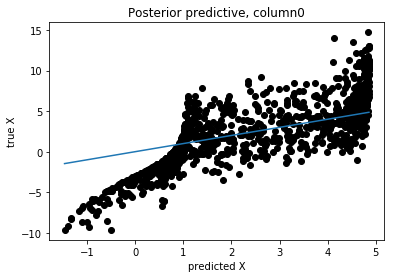

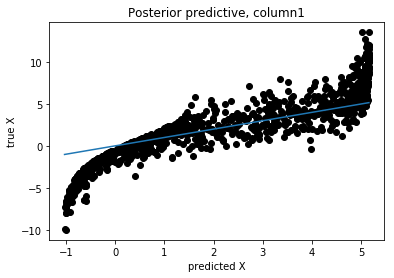

In [43]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [44]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[ 1.10073553 -1.12680605]
 [ 4.871117    5.16491909]
 [-1.68552985  1.57528819]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]]
[[ 1.05130482 -1.05754116]
 [ 4.85864979  5.15490171]
 [-1.74966231  1.58719412]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]
 [ 2.49630269  2.34514556]]
l1 difference (normalized) between means:  0.0108609291387


In [48]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_vector() - newton_results.vb_params.get_vector())))

l1 difference (normalized) between all params:  0.00686976408475


# Parametric sensitivity analysis

In particular, we are interested in how posterior quantities depend on our choice of DP parameter $\alpha$. 

As a first step, lets manually perturb $\alpha$ and re-optimize. We will then compare these perturbed results with the sensitivity predicted by LRVB. 

In [49]:
epsilon = 0.1 # how much we will perturb alpha

model_perturbed = deepcopy(newton_results)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6))

model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 
model_perturbed.set_optimal_z()

Optimization terminated successfully.
         Current function value: 3790.925948
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
done :o


In [53]:
model_perturbed.vb_params['global']['v_sticks'].e()

array([[ 0.36889588,  0.63110412],
       [ 0.76816648,  0.23183352],
       [ 0.98581047,  0.01418953],
       [ 0.32258065,  0.67741935],
       [ 0.32258065,  0.67741935],
       [ 0.32258065,  0.67741935],
       [ 0.32258065,  0.67741935],
       [ 0.32258065,  0.67741935],
       [ 0.32258065,  0.67741935]])

In [50]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian evals all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

L_inf norm of gradient:  8.64748673435e-08
time to compute Hessian (sec):  10.227798700332642
Hessian evals all positive:  True
distance (l2) to minimizer of quadratic approx. :  1.42108532944e-06


Now, lets do LRVB and get predicted sensitivities for various posterior quantities

### V_stick sensitivity

As a first pass, we look at the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [51]:
def get_v_sticks(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    return model.vb_params['global']['v_sticks'].e()[:,0]

# compute LRVB sensitivity
alpha_sensitivity = lrvb.DPAlphaSensitivity(model, newton_tr_opt.x)
lrvb_sens_v_sticks = alpha_sensitivity.get_param_sensitivity(lambda x : get_v_sticks(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_v_sticks)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = newton_results.vb_params['global']['v_sticks'].e()[:,0]

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

evaluating hessian ...
ok
LRVB predicted_sensitivity: 
 [-0.00108594 -0.00217342 -0.00660245 -0.11111111 -0.11111111 -0.11111111
 -0.11111111 -0.11111111 -0.11111111]
true sensitivity: 
 [-0.00108359 -0.0021699  -0.00659476 -0.10752688 -0.10752688 -0.10752688
 -0.10752688 -0.10752688 -0.10752688]


### Cluster mean sensitivity

We can also check the sensitivity of posterior means to $\alpha$. 

In [54]:
def get_cluster_means(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()
    
    return model.vb_params['global']['mu'].get_vector()

# compute LRVB sensitivity
lrvb_sens_means = alpha_sensitivity.get_param_sensitivity(lambda x : get_cluster_means(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_means)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['mu'].get_vector()
old_mean = newton_results.vb_params['global']['mu'].get_vector()

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

LRVB predicted_sensitivity: 
 [  3.15809493e-03  -4.04949565e-03   4.64264347e-04   1.05428559e-04
   6.87434683e-03  -1.80681021e-03  -9.02211282e-20   1.26385798e-19
  -9.02211282e-20   1.26385798e-19  -9.02211282e-20   1.26385798e-19
  -9.02211282e-20   1.26385798e-19  -9.02211282e-20   1.26385798e-19
  -9.02211282e-20   1.26385798e-19  -9.02211282e-20   1.26385798e-19]
true sensitivity: 
 [ 0.00314781 -0.00403676  0.00046326  0.00010521  0.00685227 -0.00180184
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.        ]


### Co-clustering sensitivity

Since this is a clustering problem, we can check other moments too: like co-clustering. In particular, for two data points indexed by $n_1$ and $n_2$, we can check the sensitivty of $E[z_{n_1} \cdot z_{n_2}]$, the indicator that $x_{n_1}$ and $x_{n_2}$ belong to the same cluster.

In [55]:
def get_co_clustering(model, global_free_params, n1, n2): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    e_z1 = model.vb_params['local']['e_z'].get()[n1, :]
    e_z2 = model.vb_params['local']['e_z'].get()[n2, :]
    
    return np.dot(e_z1, e_z2)

cluster of first data point:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 1.10073553 -1.12680605]
cluster mean of first data point:  [ 4.871117    5.16491909]

here, black are data points. red are the true means. 
blue are the posterior means. yellow are the chosen data points. 


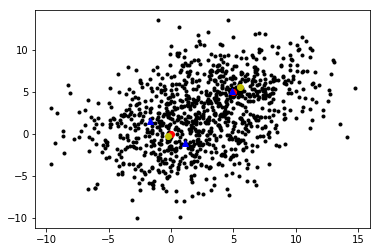

In [56]:
# choose two data points
n1 = 0
n2 = 1

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. yellow are the chosen data points. ')

In [57]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)
co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)


predicted_sensitivity: 
 -0.000326516514747
true_sensitivty: 
 -0.000325481742835


cluster of first data point:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 1.10073553 -1.12680605]
cluster mean of first data point:  [ 1.10073553 -1.12680605]

here, black are data points. red are the true means. 
blue are the posterior means. yellow are the chosen data points. 


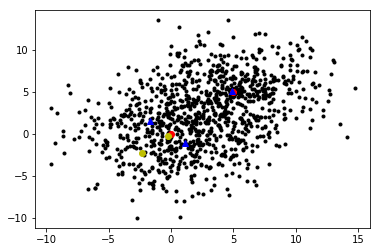

In [58]:
# choose two data points
n1 = 0
n2 = 2

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. yellow are the chosen data points. ')


In [59]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)

co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)

predicted_sensitivity: 
 -0.00131239212985
true_sensitivty: 
 -0.00130848734629


so we see that the co-clustering of two data points which are close is more sensitive to alpha than two data points that are far away

## Let us check the linearity of the perturbation in alpha

In [66]:
epsilons = np.arange(-1.0, 10, 1.0) # the range for which we will perturb alpha

results = np.zeros((len(epsilons), model.vb_params.free_size()))

for i in range(len(epsilons)): 
    print(epsilons[i])
    model_perturbed = deepcopy(newton_results)
    model_perturbed.alpha  = alpha + epsilons[i] # perturb dp parameter

    # define new objective
    kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

    # find new optima
    opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6), disp = False)
    
    # set to optima
    model_perturbed.vb_params['global'].set_free(opt_perturbed.x) 
    model_perturbed.set_optimal_z()
    
    results[i, :] = model_perturbed.vb_params.get_free()    

-1.0
done :o
0.0


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)


done :o
1.0
done :o
2.0
done :o
3.0
done :o
4.0
done :o
5.0
done :o
6.0
done :o
7.0
done :o
8.0
done :o
9.0
done :o


In [67]:
k_stick = 1

perturbed_v_sticks = np.zeros(len(epsilons))
perturbed_co_clusters = np.zeros(len(epsilons))

for i in range(len(epsilons)): 
    model.vb_params.set_free(results[i,:])
    perturbed_v_sticks[i] = model.vb_params['global']['v_sticks'].e()[k_stick, 0]
    
    perturbed_co_clusters[i] = np.dot(model.vb_params['local']['e_z'].get()[n1, :], \
                                model.vb_params['local']['e_z'].get()[n2, :])


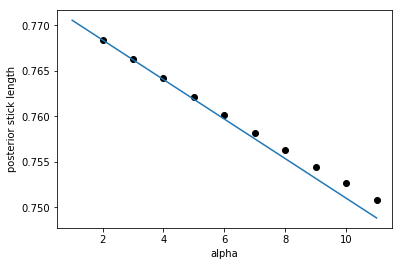

In [68]:
plt.plot(alpha + epsilons[1:], perturbed_v_sticks[1:], 'ko')
# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_mean = newton_results.vb_params['global']['v_sticks'].e()[k_stick, 0]
plt.plot(x_axis, lrvb_sens_v_sticks[k_stick] * (x_axis - alpha) + old_mean)
plt.xlabel('alpha')
plt.ylabel('posterior stick length')

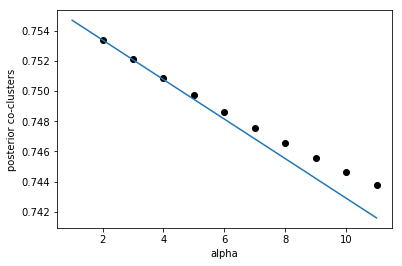

In [69]:
plt.plot(alpha + epsilons[1:], perturbed_co_clusters[1:], 'ko')

# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_co_cluster = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
                                newton_results.vb_params['local']['e_z'].get()[n2, :])
plt.plot(x_axis, lrvb_sens_co_cluster * (x_axis - alpha) + old_co_cluster)
plt.xlabel('alpha')
plt.ylabel('posterior co-clusters')